<a href="https://colab.research.google.com/github/psmjazz/corona_virus/blob/master/corona_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 코로나 데이터셋 분석
코로나 데이터셋을 바탕으로 바이러스의 전파경로를 추적하고 인사이트를 도출하고자 합니다.

In [0]:
import os
import pandas as pd
import csv

import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
%matplotlib inline

import folium
import json

from IPython.display import display

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
current_dir = os.getcwd()
print('current directory : ' + current_dir)
folder = current_dir + '/drive/My Drive/dacon'

# dataset 로드
# data_version = '/coronavirusdataset_20200328'
# data_version = '/corona/coronavirusdataset_20200407'
data_version = '/corona/coronavirusdataset_20200430'
data_dir = folder + data_version
print('data directory : ' + data_dir)
case_table = pd.read_csv(data_dir + '/Case.csv')
p_info_table = pd.read_csv(data_dir + '/PatientInfo.csv', parse_dates=['confirmed_date'])
p_route_table = pd.read_csv(data_dir + '/PatientRoute.csv')
region = pd.read_csv(data_dir + '/Region.csv')
print('dataset ok')

current directory : /content
data directory : /content/drive/My Drive/dacon/corona/coronavirusdataset_20200430
dataset ok


## 1. 슈퍼 전파자 파악
- PatientInfo 테이블의 infected_by column을 활용하여 집계하였습니다.<br>
- infected_by column 값이 null이 아닌 환자들에 대해서만 파악하였습니다.<br> 
- 편의상 바이러스를 전파한 환자를 전파자(spreader)라고 호칭하겠습니다.<br>

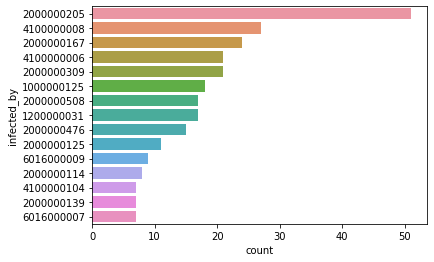

,infected_by,infection_case,count
197,2000000205,contact with patient,51
267,4100000008,gym facility in Cheonan,26
192,2000000167,contact with patient,24
264,4100000006,contact with patient,21
213,2000000309,contact with patient,21
28,1000000125,contact with patient,18
240,2000000508,contact with patient,16
235,2000000476,contact with patient,15
184,2000000125,contact with patient,11
116,1200000031,contact with patient,10


In [0]:
# spreader_count = dict()
spreader_count = None
spreader_count = p_info_table[['infected_by']]\
    .dropna(axis = 0).astype('int64')\
    .groupby('infected_by')['infected_by'].count().reset_index(name = 'count')\
    .sort_values(['count'], ascending = False)

top_spreader = spreader_count.head(15)
sns.barplot(x = 'count',y = 'infected_by',
            data = top_spreader, orient = 'h',
            order = top_spreader['infected_by'])
plt.show()

spreader_count = p_info_table[['infected_by', 'infection_case']]\
    .dropna(axis = 0)\
    .astype({'infected_by' : 'int64'})\
    .groupby(['infected_by', 'infection_case'])['infected_by'].count()\
    .reset_index(name = 'count')\
    .sort_values(['count'], ascending = False)
spreader_count.head(15)

- 가장 많이 사람들을 감염시킨 15명의 전파자입니다.<br>
    - 2000000205번 전파자가 51명으로 가장 많이 감염시켰으며<br>
감염된 환자들의 infection_case는 contact with patient입니다.<br>
    - 1200000031번 전파자는 contact with patient와 Shincheonji Church로 infection_case가 나뉘었습니다.<br>
- 대부분의 infection case가 contact with patient입니다.


In [0]:
infection_count = p_info_table[['infected_by', 'infection_case']]\
    .dropna(axis = 0)\
    .astype({'infected_by' : 'int64'})\
    .groupby(['infection_case'])['infection_case'].count()\
    .reset_index(name = 'count')\
    .sort_values(['count'], ascending = False)
infection_count

,infection_case,count
9,contact with patient,753
11,gym facility in Cheonan,26
7,Shincheonji Church,7
1,Eunpyeong St. Mary's Hospital,6
13,overseas inflow,6
2,Geochang Church,4
5,Onchun Church,4
10,etc,4
12,gym facility in Sejong,4
3,Guro-gu Call Center,2


- infection_case의 값이 contact with patient인 경우가 많아 infection_case 별로 집계해 보았습니다.
    - 대부분의 infection_case가 contact with patient 였습니다.
    - 큰 이슈가 되었던 신천지 교회나 구로구 콜센터 집단 감염의 infection_case는 생각보다 적었습니다.
- 아마도 개인정보 보호를 위해 신상이 드러나기 쉬운 infection_case에 대한 전파자 정보가 제공되지 않은 것 같습니다.

## 2. 감염경로 추적
- infected_by column의 정보를 바탕으로 바이러스의 전파경로를 추적해 보았습니다.<br>
- 환자간 전파 관계를 그래프로 만들어 breadth-first search를 적용하여 지도에 표시했습니다.<br>
- 지도에서 환자의 위치는 PatientInfo 테이블의 province와 city column의 위치를 기준으로 했습니다.<br>
- province와 city의 위치는 Region 테이블의 좌표를 사용했습니다.<br>


###**관련 함수**
전파경로 추적을 위한 함수들입니다.
- Order 클래스 : 지도에 점(환자)들을 표현할 때 city 내 환자가 많다면 알아보기 힘듭니다.<br>보기 편하게 점들을 가지런하게 배치해 줍니다.
- get_location, get_city_name : 각각 city 와 province의 좌표와 도시명을 반환합니다.
- draw_spreading_line : 바이러스의 전파경로를 표현합니다.
    - 같은 city 내 전파와 다른 city로 전파를 구분하여 그렸습니다.
    - 전파 차수마다 각기 다른 색을 사용했습니다.
- draw_spreader : 그래프내 사이클 처리 함수입니다.
    - 사이클이란 전파자 A로부터 시작된 바이러스 전파가 다시 A에게 전파된 특수한 경우입니다.
    - 사이을 구성하는 노드들의 색은 전부 흰색입니다.

In [0]:
# 같은 지역 내에 속하는 환자들을 점으로 표현하는데
# 점들을 보기 좋게 정렬하는 클래스
# rect_size : city나 province를 표현하는 사각형의 한변 길이
# rows : 사각형 안에 점(환자)들을 표현할 행수
# cols : 사각형 안에 점(환자)들을 표현할 열수
class Order:
    def __init__(self, rect_size = 0.004, rows = 10, cols = 10):
        self.region_count = dict() # bfs를 돌면서 해당 지역의 환자 수 누적
        self.patient_pos = dict() # 각 점(환자)의 사각형 내 위치
        for city in region['city']:
            self.region_count[city] = 0
        self.rows = rows
        self.cols = cols
        self.lat_interval = rect_size / (rows + 1)  # 점(환자)들 사이
        self.long_interval = rect_size / (cols + 1) # 위도 경도 간격 계산
        self.lat_init = rect_size / 2 - self.lat_interval    # 첫번째 점(환자)의
        self.long_init = -rect_size / 2 + self.long_interval # 좌표
        self.epsilons = np.arange(-self.lat_interval/4, self.lat_interval/4, self.lat_interval/ cols)
        self.epsilon_len = len(self.epsilons)
        
    def set_loc(self, patient_id, city_name): # 점(환자)의 좌표 계산
        num = None
        epsilon = None
        if patient_id in self.patient_pos:
            num, epsilon = self.patient_pos[patient_id]
        else:
            num = self.region_count[city_name]
            # eps_len = len(self.epsilons)
            epsilon = self.epsilons[np.random.randint(self.epsilon_len)]
            self.patient_pos[patient_id] = (num, epsilon)
            self.region_count[city_name] += 1
        row = num // self.rows
        col = num % self.rows
        latitude_jit = self.lat_init - self.lat_interval * row + epsilon
        longitude_jit = self.long_init + self.long_interval * col
        return latitude_jit, longitude_jit

def get_location(info): #  환자의 province, city정보에 대한 좌표 
    info = info.reset_index()
    region_info = None
    city = info.loc[0, 'city']
    province = info.loc[0, 'province']
    if city is np.nan or city ==  'etc': # city 값이 NaN이거나 'etc'인 경우
        region_info = region[region['province'] == province]
    else:
        region_info = region[(region['province'] == province) & (region['city'] == city)]
    return region_info.reset_index().loc[0, ['latitude', 'longitude']]

def get_city_name(info):
    info = info.reset_index()
    if info.loc[0, 'city'] is np.nan or info.loc[0, 'city'] ==  'etc':
        return info.loc[0, 'province']
    else:
        return info.loc[0, 'city']

# 1차~6차 전파 : 1차       2차       3차      4차     5차       6차
depth_color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
# 전파자와 감염자 사이 에지를 지도에 표현
# spreader : 전파자의 patient_id column 값
# patient : 감염자의 patient_id column 값
# depth : 그래프의 깊이 == 전파 횟수
# m : folium 지도 객체
# order : 지도 내 점들을 보기 편하게 정렬하는 oder 클래스
def draw_spreading_line(spreader, patient, depth, m, order):
    spreader_info = p_info_table[p_info_table['patient_id'] == spreader]
    patient_info = p_info_table[p_info_table['patient_id'] == patient]
    spreader_pos = list(get_location(spreader_info))
    patient_pos = list(get_location(patient_info))
    spreader_city = get_city_name(spreader_info)
    patient_city = get_city_name(patient_info)

    jit_s_lat, jit_s_long = order.set_loc(spreader, spreader_city)
    jit_p_lat, jit_p_long = order.set_loc(patient, patient_city)
    color = (lambda x : depth_color[depth] if type(x) is int else x)(depth)

    if(depth == 0): #1차 전파자 표시
        inform = (
            str(spreader)
            + ' ('+ spreader_info['province'].to_string(index = False)
            + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(spreader_info['city'])
            + ') start'
        )
        spreader_case = spreader_count[spreader_count['infected_by'] == spreader]
        for i in range(len(spreader_case)):
            case = spreader_case.iloc[i]
            where = case['infection_case']
            count = case['count']
            inform += f'<br>{count: 3} patients : {where}'
        inform += (
            '<br>total contact_number : '
            + (lambda x : str(int(x.values[0])) if not np.isnan(x.values[0]) else '?')(spreader_info['contact_number'])
        )
        lat = spreader_pos[0] + jit_s_lat
        longi = spreader_pos[1] + jit_s_long
        folium.CircleMarker(
            location=(lat, longi), 
            fill_color = color,
            fill_opacity =1.0,
            color = color,
            radius=4,
            weight = 2,
            tooltip = inform
        ).add_to(m)

    inform = ( # 툴팁에 표시될 데이터
        str(patient)
        + ' ('+ patient_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['city'])
        + ' infected by '
        + str(spreader)
        + ' ('+ spreader_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(spreader_info['city'])
        + ' )<br>infection case : '
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['infection_case'])
        + '<br>total contact number : '
        + (lambda x : str(int(x.values[0])) if not np.isnan(x.values[0]) else '?')(patient_info['contact_number'])
    )

    if spreader_pos == patient_pos: # 같은 city 내 감염자 에지
        spreader_pos[0] += jit_s_lat
        spreader_pos[1] += jit_s_long
        patient_pos[0] += jit_p_lat
        patient_pos[1] += jit_p_long
        folium.PolyLine(
            locations = [spreader_pos, patient_pos],
            color = color,
            weight = 1,
            tooltip = inform
        ).add_to(m)
        folium.CircleMarker(
            location=patient_pos, 
            fill_color = color,
            color = color,
            radius=4, 
            weight = 2,
            tooltip = inform
        ).add_to(m)
    else: # 다른 city간 감염자 에지
        spreader_pos[0] += jit_s_lat
        spreader_pos[1] += jit_s_long
        patient_pos[0] += jit_p_lat
        patient_pos[1] += jit_p_long
        folium.PolyLine(
            locations = [spreader_pos, patient_pos],
            color = color,
            weight = 1,
            tooltip = inform
        ).add_to(m)
        folium.RegularPolygonMarker(
            location=patient_pos, 
            fill_color=color,
            fill_opacity = 0.2,
            color =  color,
            number_of_sides=4, 
            radius=7, 
            weight = 2,
            tooltip = inform
        ).add_to(m)

def draw_no_spreader(spreader, patient, depth, m, order):
    patient_info = p_info_table[p_info_table['patient_id'] == patient]
    patient_pos = list(get_location(patient_info))
    patient_city = get_city_name(patient_info)

    inform = (
        str(spreader)
        + ' ( ??? ) ->'
        + str(patient)
        + ' ('+ patient_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['city'])
        + ' )<br>infection case : '
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['infection_case'])
        + '<br>total contact number : '
        + (lambda x : str(int(x.values[0])) if not np.isnan(x.values[0]) else '?')(patient_info['contact_number'])
    )

    jit_p_lat, jit_p_long = order.set_loc(patient, patient_city)
    patient_pos[0] += jit_p_lat
    patient_pos[1] += jit_p_long
    color = (lambda x : depth_color[x] if type(x) is int else cycle_color)(depth)
    folium.CircleMarker(
        location=patient_pos, 
        fill_color = color,
        color = color,
        radius=4, 
        weight = 2,
        tooltip = inform
    ).add_to(m)

def draw_cycle(spreader, patient, color, m, order):
    spreader_info = p_info_table[p_info_table['patient_id'] == spreader]
    patient_info = p_info_table[p_info_table['patient_id'] == patient]
    spreader_pos = list(get_location(spreader_info))
    patient_pos = list(get_location(patient_info))
    spreader_city = get_city_name(spreader_info)
    patient_city = get_city_name(patient_info)

    inform = (
        str(patient)
        + ' ('+ patient_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['city'])
        + ' infected by '
        + str(spreader)
        + ' ('+ spreader_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(spreader_info['city'])
        + ' )<br>infection case : '
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['infection_case'])
        + '<br>total contact number : '
        + (lambda x : str(int(x.values[0])) if not np.isnan(x.values[0]) else '?')(patient_info['contact_number'])
    )

    jit_s_lat, jit_s_long = order.set_loc(spreader, spreader_city)
    jit_p_lat, jit_p_long = order.set_loc(patient, patient_city)
    spreader_pos[0] += jit_s_lat; spreader_pos[1] += jit_s_long
    patient_pos[0] += jit_p_lat; patient_pos[1] += jit_p_long

    folium.PolyLine(
            locations = [spreader_pos, patient_pos],
            color = color,
            weight = 1,
            tooltip = inform
        ).add_to(m)
    folium.CircleMarker(            
        location=patient_pos, 
        fill_color = color,
        fill_opacity =1.0,
        color = color,
        radius=4,
        weight = 2,
        tooltip = inform
    ).add_to(m)

In [0]:
patient_and_spreader = p_info_table[['patient_id', 'infected_by']].dropna(axis = 0).astype('int64')
infection_route = dict()
rir = dict()
# spreader_root = set()
# child = set()
for i in patient_and_spreader.index:
    patient = patient_and_spreader.loc[i, 'patient_id']
    spreader = patient_and_spreader.loc[i, 'infected_by']
    
    rir[patient] = spreader
    if spreader in infection_route:
        infection_route[spreader].append(patient)        
    else:
        infection_route[spreader] = [patient]
# infection_route : 전파자의 patient_id가 key,
# 피전파자의 patient_id 리스트를 value인 dictionary (1 : N)
# rir : reverse infection route
# 피전파자의 patient_id가 key, 전파자의 patient_id가 value인 dictionary (1 : 1)
#infection_route는 여러개의 트리가 모인 그래프 형태

### 트리 구성 & 사이클 제거
spreader_root = set() # 트리 루트 노드를 담는 set
cycles = [] # 사이클 리스트
for spreader in infection_route.keys():
    maybe_cycle = [spreader]
    while spreader in rir:
        spreader = rir[spreader]
        ### 사이클 제거 시작
        if spreader in maybe_cycle:
            idx = maybe_cycle.index(spreader)
            candidate = maybe_cycle[idx:] # 사이클의 후보 : 과거에 발견된 사이클과 
                                          # 겹칠 수 있다.            
            for cycle in cycles: # (for_1) 현재까지 발견한 사이클에서
                for node in candidate: # (for_2) candidate의 사이클을 이루는 노드를
                    if node not in cycle: # 하나씩 검사
                        break # (for_2) break
                else: # 이미 존재하는 사이클과 노드 구성이 일치하는 경우
                      # -> 똑같은 사이클이 존재
                    if len(cycle) == len(candidate): break # (for_1) break
            else: # (for_1)이 정상적으로 종료(==(for_1) break문에 빠지지 x)
                  # -> 새로운 사이클
                cycles.append(maybe_cycle[idx:])
            break
        ### 사이클 제거 끝
        maybe_cycle.append(spreader)
    spreader_root.add(spreader)


###**bfs 및 특이값**
위에서 생성한 그래프를 바탕으로 breadth-first serch를 수행합니다.
- 먼저 각 Reagion 테이블로부터 얻은 city의 좌표값을 가지고서<br>해당 city를 나타내는 사각형을 그립니다.
- bfs를 통해 전파경로를 구합니다.
    - 환자의 infected_by column에 등장하지만<br>PatientInfo 테이블에 존재하지 않는 환자들에 대한 예외처리를 진행합니다.
    - 전파자가 서로를 감염시키는 사이클에 대한 예외처리를 진행합니다.

In [0]:
center = [36.641876, 127.488759]
rect_size = 0.004  # 해당 도시의 좌표값을 중심으로 하는 0.004크기의 사각형
display_order = Order(rect_size, 10, 10) # 한 city당 10 * 10의 점을 표시
m = folium.Map(location=center
               , zoom_start=8
               , tiles = 'cartodbpositron'
               )
# city를 나타내는 사각형 그리기
for i in range(len(region)):
    if i == len(region) - 1: # Region 테이블의 마지막 row : Korea -> Seoul과 위치 겹침
        continue             # 또한 patient_info에서는 province로 korea 사용 x
    loc = region.loc[i, ['latitude', 'longitude']]
    province = region.loc[i, ['province']].to_string(index = False) 
    city = region.loc[i, ['city']].to_string(index = False) 
    inform = (province + ' ' + (lambda x : x if x != province else '')(city))

    folium.Rectangle(
        bounds = (loc + [rect_size / 2, -rect_size/2]
                  , loc + [-rect_size/2, rect_size/2]), 
        radius = 180,
        color = 'black',
        fill_color='black',
        tooltip = inform
    ).add_to(m)

# Breadth-first search를 통한 감염 단계 탐색
print('case 1 : 전파자 정보 없음')
visited = []
queue = []
for starter in spreader_root:
    visited.append(starter)
    queue.append((starter, 0))

while len(queue) > 0:
    spreader, depth = queue[0]
    queue.pop(0)
    for patient in infection_route[spreader]:
        try:
            draw_spreading_line(spreader, patient, depth, m, display_order)
        except KeyError:
            print('spreader id does not exist : ' + str(spreader) + ' patient : ' + str(patient))
            draw_no_spreader(spreader, patient, depth, m, display_order)
        if patient in infection_route and patient not in visited:
            queue.append((patient, depth +1))
            visited.append(patient)

# 사이클 표시
print('\ncase 2 : cycle 발생')
n = 1
for cycle in cycles:
    print(f'cycle {n}')
    n+=1
    for node in cycle:
        patient = p_info_table.loc[p_info_table['patient_id'] == node, ['patient_id', 'infected_by']].astype('int64').values[:]
        print(f'patient {patient[0, 0]} infected by {patient[0, 1]}') 
    
    cycle.append(cycle[0])          
    for i in range(len(cycle)-1):
        try:
            draw_cycle(cycle[i], cycle[i+1], 'white', m, display_order)
        except:
            print('spreader id does not exist : ' + str(spreader) + ' patient : ' + str(patient))
    cycle.pop()   

case 1 : 전파자 정보 없음
spreader id does not exist : 2017000005 patient : 1000000062
spreader id does not exist : 6100000384 patient : 6100000034
spreader id does not exist : 6100000384 patient : 6100000035
spreader id does not exist : 6100000384 patient : 6100000036
spreader id does not exist : 2002000001 patient : 1000000003

case 2 : cycle 발생
cycle 1
patient 1100000028 infected by 1100000028
cycle 2
patient 1300000011 infected by 1300000010
patient 1300000010 infected by 1300000011
cycle 3
patient 4100000006 infected by 4100000007
patient 4100000007 infected by 4100000006
cycle 4
patient 4100000070 infected by 4100000052
patient 4100000052 infected by 4100000070
cycle 5
patient 4100000118 infected by 4100000116
patient 4100000116 infected by 4100000118
cycle 6
patient 4100000122 infected by 4100000121
patient 4100000121 infected by 4100000122
cycle 7
patient 6009000008 infected by 6009000007
patient 6009000007 infected by 6009000008
cycle 8
patient 6100000066 infected by 6100000066


- case 1 : 전파자가 table에 없는 경우입니다. 이럴 경우 피전파자만 지도에 표시했습니다.<br> PationtInfo가 한국에서 발생한 전체 환자 데이터셋이 아니어서 발생하는 문제 같습니다.
- case 2 : 전파자가 서로를 감염시키는 사이클이 형성된 경우입니다.<br> 흰색의 점과 선으로 표시했습니다.


###**전파 경로 추적 지도**
- 검은 사각형은 city 또는 province를 나타냅니다.
- 전파 차수에 따라 다른 색으로 표현했습니다.
    - 1차 전파 : <font color = 'red'>빨강</font>
    - 2차 전파 : <font color = 'orange'>주황</font>
    - 3차 전파 : <font color = 'yellow'>노랑</font>
    - 4차 전파 : <font color = 'green'>초록</font>
    - 5차 전파 : <font color = 'blue'>파랑</font>
    - 6차 전파 : <font color = 'purple'>보라</font>
- 전파의 시작점은 속이 채워진 원으로 표기했습니다.
- 같은 지역 내에서 전파된 환자는 속이 빈 원으로 표기했습니다.
- 다른 지역으로 전파된 환자는 속이 빈 마름모로 표기했습니다.
- 사이클은 흰색으로 표기했습니다.

In [0]:
m

- 전파 경로를 그려보니 수도권 지역에 데이터가 편중되어 있었습니다.

##3. 집단 감염 파악
- 추적한 전파 경로의 경우 infection_case가 'contact with patient' 인 경우가 많았습니다.
- 이외의 집단 감염 사례는 소수였기 때문에 데이터 전체의 분포를 확인하기는 어렵습니다.
- 따라서 집단 감염 사례들을 집계하여 실제 감염 분포를 알아보고자 합니다.

### **감염 인원 집계**
- province 를 기준으로 감염인원을 짐계했습니다.

In [0]:
SEOUL_COORDINATES = (37.566345, 126.977893)
state_geo_path = folder + '/geodata/CTPRVN_201905/TL_SCCO_CTPRVN_WGS84.json'
state_geo=json.load(open(state_geo_path, encoding = 'UTF-8'))
state_geo['features'][7]['properties']['CTP_ENG_NM'] = 'Sejong' # Sejong-si -> Sejong
state_geo['features'][13]['properties']['CTP_ENG_NM'] = 'Jeollanam-do' # Jellanam-do -> Jeollanam-do
Data = pd.read_csv(data_dir+'/Case.csv')
DataDF = pd.pivot_table(Data,index='province',aggfunc=np.sum)
Data_map = folium.Map(location=SEOUL_COORDINATES, zoom_start=7)

bins_term = [0,100,500,1000,2000,10000]
folium.Choropleth (geo_data = state_geo,
               data = DataDF['confirmed'],
               columns = [DataDF.index, DataDF['confirmed']],
               key_on='feature.properties.CTP_ENG_NM',
               fill_color='PuRd',
               fill_opacity=0.7,
               line_opacity=0.2,
               legend_name='confirmed',
               bins = bins_term,
               reset=True
               ).add_to(Data_map)

###**infection case 별 집계**
- infection case 별로 감염인원을 집계했습니다.
- 집단 감염자와 비집단 감염자의 비율을 원그래프 비율로 표현했습니다.
- 전체 감염사례의 수치에 따라 지도위에 붉은 색상으로 표현했습니다.
- 붉은 색상의 농도가 짙을 수록 감염자 수치가 높은 지역입니다.
- 집단 감염 사례는 지도 위에 마커를 활용하여 표시하였습니다.
- 마커를 클릭할 시 집단 감염 방생 case와 수치가 표현되어 있습니다. 


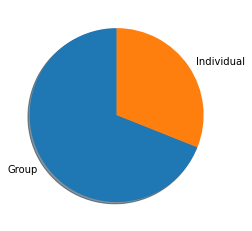

In [0]:

group_local_data = []
group_case = 0
individual_case = 0
labels_group = ['Group','Individual']
with open(data_dir + '/Case.csv','r', encoding = 'UTF-8') as f:
    reader = csv.DictReader(f)
    for i in reader:
        temp_local_data = []
        if i['group']=='TRUE':
            group_case += int(i['confirmed'])
            try:
                temp_local_data = [float(i['latitude']),float(i['longitude'])]
                if temp_local_data not in group_local_data:
                    group_local_data.append(temp_local_data)
                    info_popup = folium.Popup(
                        '*Case :'+i['infection_case']+'<br>'+'*Number :'+i['confirmed'],
                        max_width = 300,
                    )
                    folium.Marker(
                        temp_local_data,
                        popup=info_popup,
                        icon=folium.Icon(color='red',icon='info-sign')
                    ).add_to(Data_map)
            except:
                pass
        else:
            individual_case += int(i['confirmed'])
    labels_group = ['Group','Individual']
    ratio_group = [group_case,individual_case]
    plt.pie(ratio_group,labels=labels_group,shadow=True,startangle=90)
    plt.show()
display(Data_map)

- 감염 사례는 집단 감염이 60%, 개별 감염이 40% 정도로 나타났습니다.
- 감염 건수는 수도권지역과 경상도 지역에서 많이 발생했습니다. 
- 전파 경로 지도에선 수도권 지역에서 수많은 바이러스 전파가 일어났지만<br>
실제로는 대구지역의 환자가 훨씬 많이 발생한 것을 볼 수있습니다. ( infection_case : shincheonji church)
- contact with patient만 따진다면 유동인구가 많은 수도권에서 가장 많은 환자가 발생했겠지만<br>
예측할 수 없는 변수 (shinchenji church)로 인해 바이러스가 경상도 지역에 퍼졌음을 알 수 있습니다.

##4. 환자들의 이동경로가 확산에 미친 영향

In [0]:
check_table = spreader_count[(spreader_count['infected_by'] == 1200000031) | (spreader_count['infected_by'] == 4100000008)].sort_values(['infected_by'])
display(check_table)

,infected_by,infection_case,count
116,1200000031,contact with patient,10
115,1200000031,Shincheonji Church,7
267,4100000008,gym facility in Cheonan,26
266,4100000008,contact with patient,1


- 1200000031번과 4100000008번 모두 집단감염의 시작점이 되었습니다.
- 하지만 두 환자의 전파 양상은 다릅니다.

In [0]:


daegu = [36.641876, 127.488759]
map_check = folium.Map(location=daegu
               , zoom_start=8
               , tiles = 'cartodbpositron'
            )
                #      대구         천안
want_to_check = [1200000031,  4100000008]
order2 = Order()

for p in want_to_check:  
    route_table_of_spreader = p_route_table[p_route_table['patient_id'] == p]
    if(len(route_table_of_spreader) != 0):
        route = np.array([
                route_table_of_spreader['latitude'].astype('float').tolist(),
                route_table_of_spreader['longitude'].astype('float').tolist()
        ]).T
        colors = np.arange(len(route)-1) / (len(route)-1)
        
        folium.ColorLine(
            positions = route,
            colors = colors,
            colormap = ['pink', 'purple'],
            weight = 2
        ).add_to(map_check)
       
    else:
        print(p)

q = [(1200000031, 1), (4100000008, 0)]
visited = [1200000031, 4100000008]
while len(q) > 0:
    spreader, color = q.pop(0)
    for patient in infection_route[spreader]:
        draw_spreading_line(spreader, patient, color, map_check, order2)
        if patient not in visited and patient in infection_route:
            q.append((patient, color))
            visited.append(patient)


display(map_check)

- 1200000031번 환자의 경우 이동 경로는 짧지만<br>
1200000031번 환자로부터 전국으로 확산되었습니다.
- 4100000008번 환자는 1200000031번 환자보다 이동 경로가 길지만<br>
4100000008번 환자가 있는 지역에서만 확산되었습니다.

In [0]:
colormaps = {1200000031 : ['#0FFF00', '#18C900'], 4100000008 : ['#0000FF', '#8B00FF']}
marker_color = {1200000031 : 'green', 4100000008 : 'blue'}

for s in want_to_check:
    contact_with_s = p_info_table[(p_info_table['infected_by'] == s)]['patient_id']
    
    for p_id in contact_with_s:
        route_info = p_route_table[p_route_table['patient_id'] == p_id]
        route = np.array([
                    route_info['latitude'].astype('float').tolist(),
                    route_info['longitude'].astype('float').tolist()
            ]).T

        if(len(route) > 1):
            colors = np.arange(len(route)-1) / (len(route)-1)
            folium.Marker(
                location = route[0],
                tooltip = f'{p_id} start',
                icon=folium.Icon(marker_color[s], prefix = 'fa', icon='circle')
            ).add_to(map_check)
            folium.ColorLine(
                positions = route,        
                colors = colors,
                colormap = colormaps[s],
                weight = 2,
            ).add_to(map_check)
            folium.Marker(
                location = route[-1],
                tooltip = f'{p_id} end',
                icon=folium.Icon(color = marker_color[s], prefix = 'fa', icon='circle')
            ).add_to(map_check)
        elif len(route) == 1:
            folium.Marker(
                location = route[0],
                tooltip = f'{p_id} start = end',
                icon=folium.Icon(color = marker_color[s], prefix = 'fa', icon='circle')
            ).add_to(map_check)
        else:
            continue
display(map_check)

- 1200000031번, 4100000008번 환자로부터 감염된 환자들의 이동경로입니다.
    - <font color = 'blue'>파란</font>선은 4100000008번 환자로부터 감염된 환자들의 이동경로입니다.<br>4100000009번 환자를 제외하고 전부 한 지점으로 모였습니다.
    - <font color = 'green'>녹색</font>선은 1200000031번 환자로부터 감염된 환자들의 이동경로입니다.<br>여러 환자가 수도권과 경상도 지역으로 이동하였고<br>
이동한 지역에서 2차 전파가 발생한 곳도 있었습니다.
- 확진자 이동경로의 마지막 위치가 확전 판정을 받은 지역과 유사하다고 가정하면<br>확진자의 이동이 바이러스의 전파에 영향을 준다고 볼 수 있습니다.

##5. 전파자와 피전파자간 확진 판정 간격
전파 경로의 사람들이


In [0]:
# patients['month'] = p_info_table['confirmed_date'].dt.month
# patients['day'] = p_info_table['confirmed_date'].dt.day

p_info_table['month'] = p_info_table['confirmed_date'].dt.month
p_info_table['day'] = p_info_table['confirmed_date'].dt.day
patients = p_info_table[['patient_id', 'month', 'day']]


In [0]:
patients

,patient_id,month,day
0,1000000001,1.0,23.0
1,1000000002,1.0,30.0
2,1000000003,1.0,30.0
3,1000000004,1.0,30.0
4,1000000005,1.0,31.0
...,...,...,...
3383,7000000009,3.0,29.0
3384,7000000010,4.0,3.0
3385,7000000011,4.0,3.0
3386,7000000012,4.0,3.0


In [0]:
# month = [0, 31, 29, 31, 30, 31]
month = [0, 31, 60, 91, 121, 152]
def get_interval(sm, sd, pm, pd):
    s_date = month[sm-1] + sd
    p_date = month[pm-1] + pd
    return p_date - s_date

visited = []
queue = []
for starter in spreader_root:
    visited.append(starter)
    queue.append(starter)

intervals = []
while len(queue) > 0:
    spreader = queue[0]
    queue.pop(0)
    try:
        s_month = int(patients[patients['patient_id'] == spreader]['month'])
        s_day = int(patients[patients['patient_id'] == spreader]['day'])
        
        for patient in infection_route[spreader]:
            p_month = int(patients[patients['patient_id'] == patient]['month'])
            p_day = int(patients[patients['patient_id'] == patient]['day'])
            interval = get_interval(s_month, s_day, p_month, p_day)
            
            if(interval < 0):
                # print(spreader , patient)
                pass
            else:
                intervals.append(interval)

            if patient in infection_route and patient not in visited:
                queue.append(patient)
                visited.append(patient)
    except:
        pass


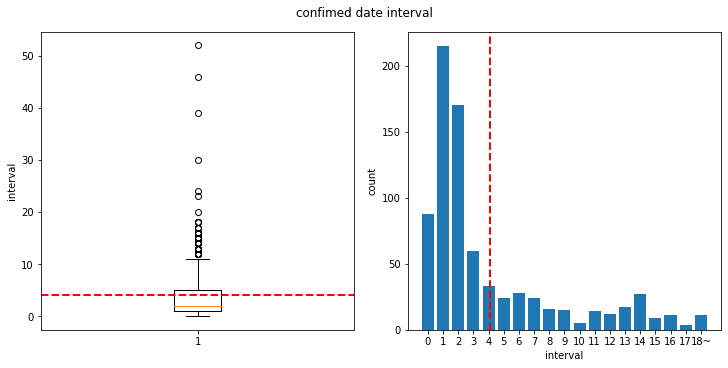

평균 4.11일 간격으로 확진판정을 받음


In [0]:
avg = np.average(intervals)

fig, axs = plt.subplots(1, 2, figsize = (10, 5), constrained_layout = True)
fig.suptitle('confimed date interval')

axs[0].boxplot(x = intervals)
axs[0].set_ylabel('interval')
axs[0].axhline(y = avg, color = 'r', linestyle = '--', linewidth = 2)

u, c = np.unique(intervals, return_counts=True)
u_18 = np.append(u[:18], np.array(['18~']))
c_18 = np.append(c[:18], np.sum(c[18:], keepdims=True))
axs[1].bar(x = u_18, height = c_18)
axs[1].set_xlabel('interval')
axs[1].set_ylabel('count')
avg = np.average(intervals)
axs[1].axvline(x = avg, color = 'r', linestyle = '--', linewidth = 2)

plt.show()
print(f'평균 {round(avg, 2)}일 간격으로 확진판정을 받음')


-  전파자와 피전파자 사이 확진 판정 간격은 대부분 0일에서 10일 사이입니다.
- 평균적으로 4.11일 간격으로 확진 판정을 받았습니다.

##6. 확진자들의 나이는?
- 전파자와 전체 확진자를 나이별로 집계해 보았습니다.

<Figure size 432x288 with 0 Axes>

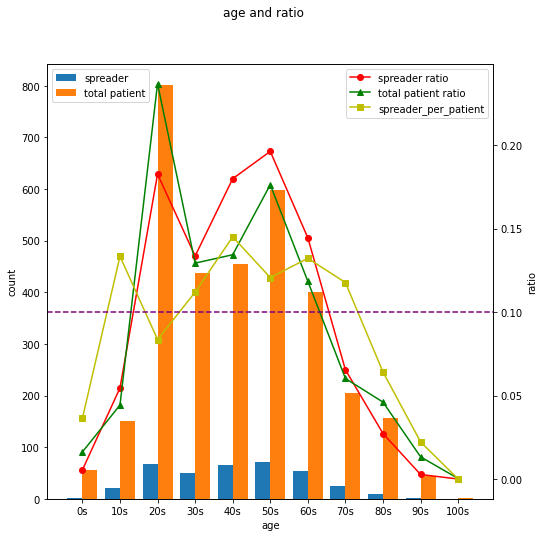

In [0]:
# 전파자의 나이별 빈도 구하기
spreaders = infection_route.keys() 
spreader_ages = []
hundred_count = 0
for s_id in spreaders:
    spreader = p_info_table[p_info_table['patient_id'] == s_id]
    if len(spreader) == 0:
        continue
    age = spreader['age'].to_string(index = False)
    if age == '100s':
        hundred_count+=1
    else: 
        spreader_ages.append(age)
spreader_age, spreader_count = np.unique(spreader_ages, return_counts=True)
spreader_age = np.append(spreader_age[:-1], ['100s'])
spreader_count = np.append(spreader_count[:-1], [hundred_count])

# 전파자의 나이별 비율
spreader_ratio = spreader_count / len(spreader_ages)

# 전체 환자의 나이별 빈도
total_ages = [] 
hundred_count = 0;
for i in range(len(p_info_table)):
    patient = p_info_table.iloc[i]
    age = patient['age']
    if age == '100s':
        hundred_count+=1
    else:
        total_ages.append(age)
patient_age, patient_count = np.unique(total_ages, return_counts = True)
patient_age = np.append(patient_age[:-1], ['100s'])
patient_count = np.append(patient_count[:-1], [hundred_count])

# 전체 환자의 나이별 비율
patient_ratio = patient_count / len(p_info_table)

# 전파자 : 전체 환자
spreader_per_patient = spreader_count / patient_count

pos = np.arange(len(patient_age))
width = 0.4
plt.clf()
fig, ax1 = plt.subplots(figsize = (8, 8))
fig.suptitle('age and ratio')

ax1.set_xlabel('age')
ax1.set_ylabel('count')
ax1.set_xticks(pos)
ax1.set_xticklabels(patient_age)
ax1.bar(
    x = pos - width/2, height = spreader_count, 
    width = width, label = 'spreader')
ax1.bar(
    x = pos + width/2, height = patient_count, 
    width = width, label = 'total patient')
ax1.legend(loc = 'upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('ratio')
ax2.plot(pos, spreader_ratio, color = 'r', 
         marker = 'o', label = 'spreader ratio')
ax2.plot(pos, patient_ratio, color = 'g', 
         marker = '^', label = 'total patient ratio')
ax2.plot(pos, spreader_per_patient, color = 'y',
         marker = 's', label = 'spreader_per_patient')
ax2.axhline(y = 0.1, color = 'purple', linestyle = '--')
ax2.legend(loc = 'upper right')

plt.show()

- 확진자중 대부분은 20대부터 60대 사이입니다.
- <font color = 'red'>빨간</font> 그래프는 해당 나이대의 전파자 비율입니다.
- <font color = 'green'>초록색</font> 그래프는 해당 나이대의 확진자 비율입니다.
- <font color = '#CCCC00'>노란색</font> 그래프는 확진자 대비 전파자 비율입니다.
- 10대부터 70대까지 확진자 대비 환자 비율은 10% 이상입니다
- 20대 환자 수가 제일 많지만 확진자 대비 전파자 비율은 10% 이하로 적은 편입니다.

##7. 결론
- 실제 환자수가 많은 것에 비해 전파자 정보('infected_by')가 적은 이유는<br>갑자기 늘어난 환자들로 인해 역학조사가 제대로 이루어지 않은 게 원인이라고 추측합니다.
- 어떤 한 사람에 의한 전파가 전국으로 퍼져나가게 된 원인은 전파자의 이동이 아니라<br>전파자와 피전파자의 접촉 이후 피전파자가 얼마나 돌아나니느냐가 원인이라고 결론지었습니다.
- 또한 외부 활동이 많은 10대 ~ 70대의 확진자 대비 전파자 비율은 10% 내외의 비율을 보였습니다.